In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import torch.nn.functional as torchF

class YLoss(nn.Module):
    def __init__(self):
        super(YLoss, self).__init__()

    def forward(self, logits, y):
        loss = nn.CrossEntropyLoss(reduction='mean')(logits, y)
        return loss


class Xloss(nn.Module):
    def __init__(self):
        super(Xloss, self).__init__()

    def forward(self, E, real, fake):
        E_real = torch.mean(E(real))
        E_fake = torch.mean(E(fake))
        loss = -(torch.mean(E_real) - torch.mean(E_fake)) 
        return loss


class SGLD(nn.Module):
    def __init__(self, std, step, init, keep_pr):
        self.init = init
        self.std = std
        self.step = step
        self.init = init
        self.keep_pr = keep_pr
        self.last_samples = []

    def make_init(self, r=0.):
        init = (1 - r) * self.init + r * torch.randn_like(self.init)
        return init
    
    def sample(self, E, n_steps, y=None):
        b_size = self.init.size(0)
        r = 1. * (torch.rand(b_size, 1, device=self.init.device) > self.keep_pr)
        init = self.make_init(r)
        x_k = torch.autograd.Variable(init, requires_grad=True)
        for t in range(n_steps):
            grad = torch.autograd.grad(E(x_k, y).sum(), [x_k], retain_graph=True)[0]
            x_k.data += self.step * grad + self.std * torch.randn_like(x_k)
        samples = x_k.detach()
        self.init = samples
        return samples

class F(nn.Module):
    def __init__(self, logit_net):
        super(F, self).__init__()
        self.logit_net = logit_net

    def E_un(self, x, y=None):
        logits = self.logit_net(x)
        energy = - torch.logsumexp(logits, 1)
        return energy

    def E_cond(self, x, y):
        logits = self.logit_net(x)
        energy = - logits[:,y]
        return energy

In [2]:
class LogitNet(nn.Module):
    def __init__(self, in_size, out_size):
        super(LogitNet, self).__init__()
        self.net = nn.Sequential(          
            nn.Linear(in_size, 15),
            nn.Tanh(),
            nn.Linear(15, out_size))
        
    def forward(self, x):
        logits = self.net(x)
        return logits

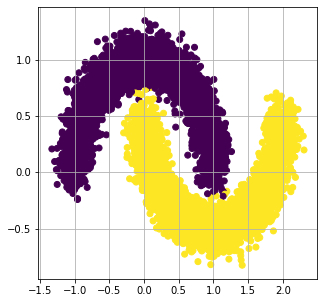

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_moons
N = int(1e4)
eps = 0.1

m_d, m_y = make_moons(n_samples=N, shuffle=True, noise=eps, random_state=None)

plt.figure(figsize=(5,5))
plt.scatter(m_d[:,0], m_d[:,1], c=m_y);
plt.grid(True)

In [4]:
points = torch.utils.data.TensorDataset(torch.from_numpy(m_d).float(), torch.from_numpy(m_y).float())
dataloader = torch.utils.data.DataLoader(points, batch_size=512)

In [5]:
y_loss = YLoss()
x_loss = Xloss()

std = 0.1
step = 0.1
init = torch.zeros((1000,2))
keep_pr = 0.95

sgld = SGLD(std, step, init, keep_pr)
logit_net = LogitNet(2,2)
f = F(logit_net)

epoch = 1000

In [6]:
def train(dataloader, epoch, lr=3e-4):
    optimizer = optim.Adam(f.parameters(), lr=lr)
    for e in range(epoch):
        e_loss = 0
        for batch in dataloader:
            X, y = batch
            logits = f.logit_net(X)
            class_loss = y_loss(logits, y.long())
            f.logit_net.eval()
            fake = sgld.sample(f.E_un, n_steps=20)
            f.logit_net.train()
            
            gen_loss = x_loss(f.E_un, X, fake)
            loss = class_loss + 1. * gen_loss   
            e_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        if e % 100 == 0: print(e, class_loss.item(), gen_loss.item(), e_loss)

In [7]:
train(dataloader, epoch)

0 0.6985364556312561 0.033523738384246826 14.867416799068451
100 0.31827056407928467 0.016720890998840332 6.981194347143173
200 0.2442009598016739 0.0002878904342651367 5.347290575504303
300 0.22481690347194672 -0.0056078433990478516 4.9728784263134
400 0.21963953971862793 -0.0035883188247680664 4.893739640712738
500 0.21689631044864655 -0.003722667694091797 4.8652617782354355
600 0.21488243341445923 -0.0015952587127685547 4.8557556718587875
700 0.2120545357465744 -0.006516695022583008 4.786233007907867
800 0.20880942046642303 -0.00572657585144043 4.6893836706876755
900 0.20595012605190277 -0.0044095516204833984 4.653885021805763


# Unconditional Samples

In [60]:
std = 0.1
step = 0.1
init = torch.zeros((1000,2))
keep_pr = 0.95

sgld = SGLD(std, step, init, keep_pr)
fake = sgld.sample(f.E_un, n_steps=20, y=None).to('cpu')

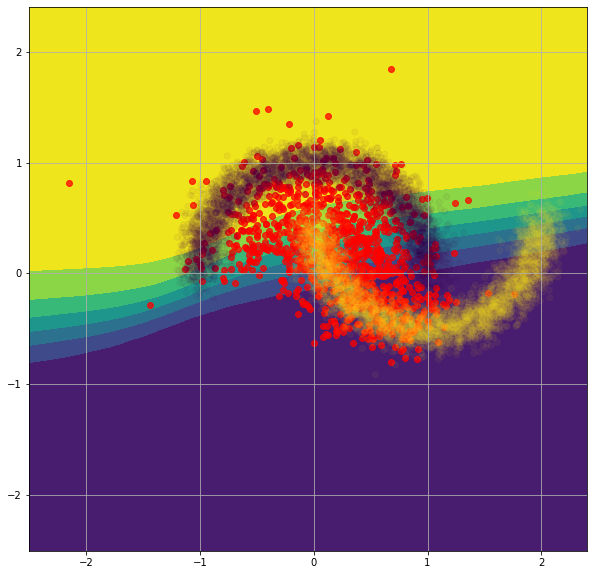

In [61]:
import numpy as np

k = -5
m_d = fake
m_d = m_d.numpy()

xx, yy = np.mgrid[-2.5:2.5:0.1, -2.5:2.5:0.1]
grid = np.c_[xx.ravel(), yy.ravel()]
a = nn.Softmax(dim=1)
probs = a(logit_net(torch.tensor(grid).float()))
probs = probs.detach().numpy()[:,0]
fig, ax = plt.subplots(1,1, figsize=(10,10))
contour = ax.contourf(xx,yy,probs.reshape(xx.shape), vmin=0., vmax=1., cmap='viridis');

ax.scatter(m_d[:,0], m_d[:,1], color='red', alpha=0.75);

m_d, m_y = make_moons(n_samples=N, shuffle=True, noise=eps, random_state=None)
ax.scatter(m_d[:,0], m_d[:,1], c=m_y, alpha=0.05);
ax.grid(True)

# Conditional Samples

## y = 0

In [66]:
std = 0.1
step = 0.1
init = torch.zeros((1000,2))
keep_pr = 0.95

sgld = SGLD(std, step, init, keep_pr)

fake = sgld.sample(f.E_cond, n_steps=20, y=0).to('cpu')

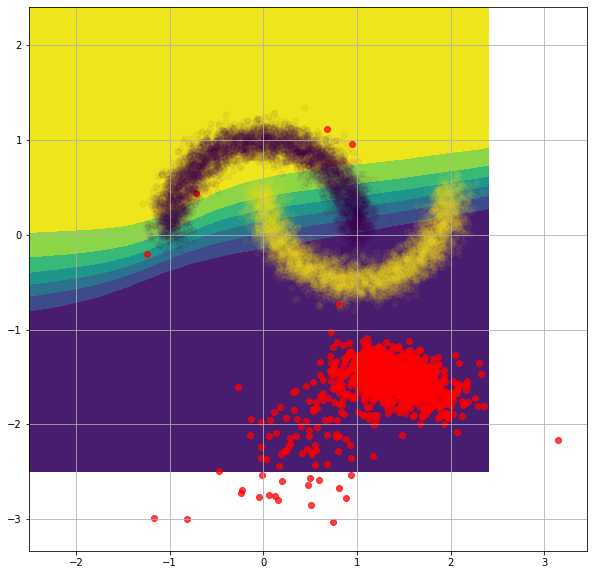

In [67]:
import numpy as np

k = -5
m_d = fake
m_d = m_d.numpy()

xx, yy = np.mgrid[-2.5:2.5:0.1, -2.5:2.5:0.1]
grid = np.c_[xx.ravel(), yy.ravel()]
a = nn.Softmax(dim=1)
probs = a(logit_net(torch.tensor(grid).float()))
probs = probs.detach().numpy()[:,0]
fig, ax = plt.subplots(1,1, figsize=(10,10))
contour = ax.contourf(xx,yy,probs.reshape(xx.shape), vmin=0., vmax=1., cmap='viridis');

ax.scatter(m_d[:,0], m_d[:,1], color='red', alpha=0.75);

m_d, m_y = make_moons(n_samples=N, shuffle=True, noise=eps, random_state=None)
ax.scatter(m_d[:,0], m_d[:,1], c=m_y, alpha=0.05);
ax.grid(True)

## y = 1

In [75]:
std = 0.1
step = 0.1
init = torch.zeros((1000,2))
keep_pr = 0.95

sgld = SGLD(std, step, init, keep_pr)

fake = sgld.sample(f.E_cond, n_steps=20, y=1).to('cpu')

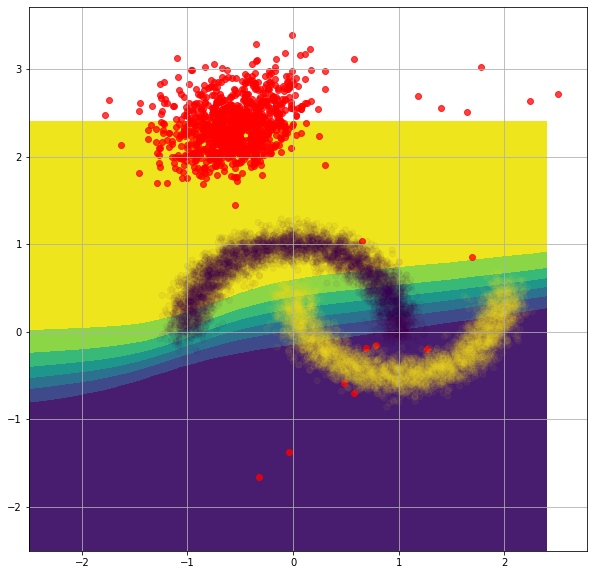

In [76]:
import numpy as np

k = -5
m_d = fake
m_d = m_d.numpy()

xx, yy = np.mgrid[-2.5:2.5:0.1, -2.5:2.5:0.1]
grid = np.c_[xx.ravel(), yy.ravel()]
a = nn.Softmax(dim=1)
probs = a(logit_net(torch.tensor(grid).float()))
probs = probs.detach().numpy()[:,0]
fig, ax = plt.subplots(1,1, figsize=(10,10))
contour = ax.contourf(xx,yy,probs.reshape(xx.shape), vmin=0., vmax=1., cmap='viridis');

ax.scatter(m_d[:,0], m_d[:,1], color='red', alpha=0.75);

m_d, m_y = make_moons(n_samples=N, shuffle=True, noise=eps, random_state=None)
ax.scatter(m_d[:,0], m_d[:,1], c=m_y, alpha=0.05);
ax.grid(True)